### Black Litterman Optimization

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import risk_models, expected_returns, BlackLittermanModel, EfficientFrontier
import yfinance as yf

TICKERS = ['AAPL','GOOGL','XOM','WMT','V','NVDA','JPM','F']
START_DATE = '2010-01-01'
END_DATE = pd.to_datetime('today')

data = yf.download(
    TICKERS, 
    start = START_DATE, 
    end = END_DATE,
    progress = False,
    interval = '1d'
)['Close']

In [43]:
spx = yf.download(
    "^GSPC", 
    start = START_DATE, 
    end = END_DATE,
    progress = False,
    interval = '1d'
)['Close']

In [44]:
market_cap = pd.Series(index = data.columns)

for asset in data.columns :
    stock = yf.Ticker(asset)
    mc = stock.info.get('marketCap')
    market_cap.loc[asset] = mc

In [45]:
market_weights = market_cap / market_cap.sum()
mu_market = spx.pct_change().mean() * 252
sigma_market = spx.pct_change().std() * np.sqrt(252)

In [46]:
rf = 0.0525
sharpe_ratio = (mu_market - rf) / sigma_market

In [47]:
delta = sharpe_ratio / sigma_market
tau = 0.05

In [48]:
viewdict = {
    'AAPL' : 0.2,
    'GOOGL' : 0.1,
    'JPM' : 0.1,
    'NVDA' : 0.3
}

In [49]:
model = BlackLittermanModel(
    cov_matrix = data.pct_change().cov(), 
    pi = "market", 
    market_caps = market_cap,
    absolute_views = viewdict,
    delta = delta,
    tau = tau
)

In [50]:
bl_returns = model.bl_returns()
bl_cov = model.bl_cov()

In [51]:
ef = EfficientFrontier(bl_returns, bl_cov)
ef.add_constraint(lambda w: w >= 0)

In [52]:
max_sharpe_weight = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

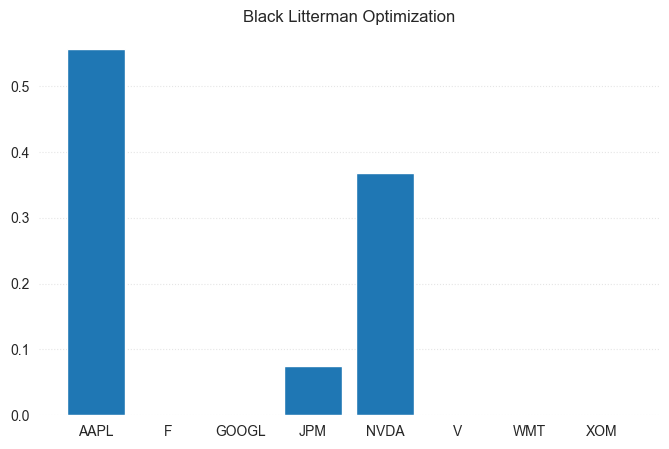

In [57]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.bar(
    cleaned_weights.keys(),
    cleaned_weights.values()
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Black Litterman Optimization')
plt.show()

In [58]:
ef.portfolio_performance(verbose=True)

Expected annual return: 14.5%
Annual volatility: 1.8%
Sharpe Ratio: 6.79


(0.14457411977271972, 0.018334692020328797, 6.79444844967108)